[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/accdavlo/calcolo-scientifico/blob/main/codes/solutions/transport_FD.ipynb)

# Heat equation

In this notebook we will solve the 1D Heat parabolic equation given 
$$\partial_t u -\partial_{xx} u = f .$$

Let us start with an example on the domain $\Omega=[0,1]$  and time domain $[0,T]$ with $T=1$ with $f=0$, homogeneous Dirichlet BC $u(0)=u(2\pi)=0$ and initial condition $u_0(x)=\sin(x)$.

In [1]:
try:
    from geometry import *
except ImportError:
    !wget https://raw.githubusercontent.com/accdavlo/calcolo-scientifico/refs/heads/main/codes/solutions/geometry.py -O geometry.py
    from geometry import *

try:
    import nodepy
except ImportError:
    !pip install nodepy
    from geometry import *
    
import numpy as np
import matplotlib.pyplot as plt

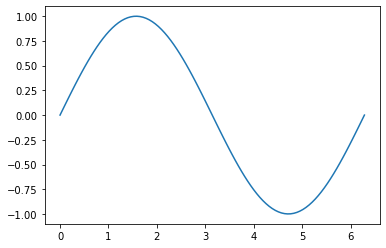

In [2]:
geom = Geometry1D(0,2*np.pi,100)
u0 = np.sin(geom.xx)
T_end = 1.
plt.plot(geom.xx,u0)

### Explicit Euler with central difference implementation
$$
\frac{u^{n+1}_i-u^n_i}{\Delta t} +a \frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}=0 
$$

Final error  605023233.2148352


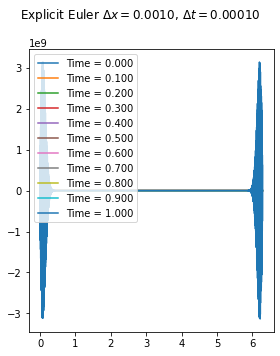

In [4]:
Nx = 6280
geom = Geometry1D(0,2*np.pi,Nx)
dt = 0.0001
u0_lambda = lambda x: np.sin(x)
u_ex = lambda t,x, a: u0_lambda(x-a*t)
T_end = 1.

class Advection_explicit_euler:
    def __init__(self, geom, T_end, u0_lambda, dt, a=1, dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.set_dt(dt)
        self.a = a
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda



    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
    
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            un1[1:-1] = un[1:-1]-self.a*self.dt/self.geom.dx/2.*(un[2:]-un[:-2])
            
            # Periodic BC
            un1[0]  = un[0] -self.a*self.dt/self.geom.dx/2.*(un[1]-un[-2])
            un1[-1] = un1[0]

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            print("Final error ",self.error)
        return self.geom.xx, un1
    
FD_approx = Advection_explicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)
xx, un1 = FD_approx.evolve()

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(FD_approx.times):
    ax1.plot(geom.xx, FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, \Delta t=%1.5f$"%(geom.dx,FD_approx.dt))
plt.tight_layout()
plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.pdf"%(geom.dx,dt))
plt.savefig("adv_central_diff_exp_eul_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()


Final error  642607668.2260965


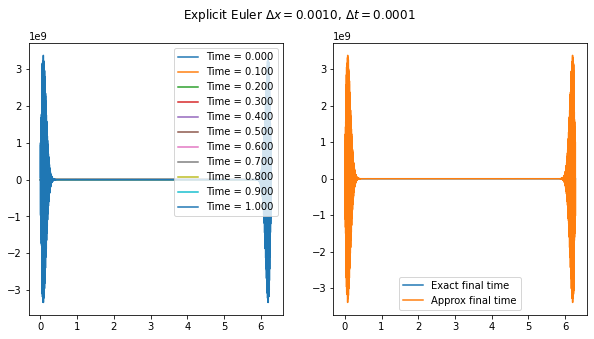

In [5]:
FD_approx.set_geom(dx=0.001)
FD_approx.set_dt(0.0001)
xx, un1 = FD_approx.evolve()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(FD_approx.times):
    ax1.plot(geom.xx, FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Explicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,FD_approx.dt))
plt.show()

### Implicit Euler

$$
\frac{u^{n}_i-u^{n-1}_i}{\Delta t} +a \frac{u_{i+1}^n-u_{i-1}^n}{2\Delta x}=0 
\Longleftrightarrow u^{n}_i-\frac{\Delta t}{2\Delta x}(u_{i+1}^n-u_{i-1}^n) = u^{n-1}_i
$$

### Linear systems with matrix
$$
\begin{pmatrix}
1 &\frac{\Delta t}{2\Delta x} & 0&\dots & \dots\\
-\frac{\Delta t}{2\Delta x} &1 &\frac{\Delta t}{2\Delta x} &\dots & \dots\\
\vdots & \ddots & \ddots & \ddots &\vdots\\
0&\dots & \dots &-\frac{\Delta t}{2\Delta x} &1     
\end{pmatrix}
$$


Final error  0.05337548029351046


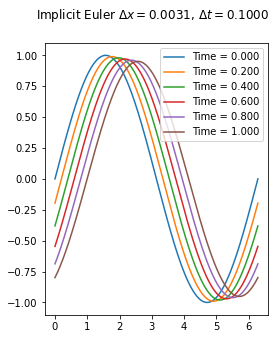

In [8]:
Nx = 2000
dt = 0.1
geom = Geometry1D(0,2*np.pi,Nx)
u0_lambda = lambda x: np.sin(x)
T_end = 1.





def assemble_deriv_matrix(geom):
    deriv_matrix = -0.5*np.diag(np.ones(geom.N-1),-1)\
                    +0.5* np.diag(np.ones(geom.N-1),1)
    # Periodic BC 
    deriv_matrix[0,-2] = -0.5
    deriv_matrix[-1,1] = 0.5
    return deriv_matrix


#def apply_BC_matrix(lhs_matrix):
#    lhs_matrix[0,:] = 0
#    lhs_matrix[0,0] = 1.
#    lhs_matrix[-1,:] = 0
#    lhs_matrix[-1,-1] = 1.


#def apply_BC_vector(rhs, uL = 0., uR = 0.):
#    rhs[0] = uL
#    rhs[-1] = uR



class Advection_implicit_euler:
    def __init__(self, geom, T_end, u0_lambda, dt, a=1.,dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.a = a
        self.set_dt(dt)
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda
        self.assemble_lhs()

    def assemble_lhs(self):
        self.deriv_matrix = assemble_deriv_matrix(self.geom)
        self.lhs_matrix = np.eye(self.geom.N) + self.a*self.dt/self.geom.dx*self.deriv_matrix
        # Periodic BC already implemented
        
        #apply_BC_matrix(self.lhs_matrix)
    
    def assemble_rhs(self,un, uL=0, uR=0):
        rhs = un
        # Periodic BC already implemented in system
        # apply_BC_vector(rhs, uL, uR)
        return rhs

    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        self.assemble_lhs() 
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
        self.assemble_lhs()
        
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            
            rhs = self.assemble_rhs(un, uL = np.sin(0.-self.a*time), uR = np.sin(2.*np.pi-self.a*time))
            un1 = np.linalg.solve(self.lhs_matrix, rhs)

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx, self.a)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            print("Final error ",self.error)
        return self.geom.xx, un1
    
IE_FD_approx = Advection_implicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)
xx, un1 = IE_FD_approx.evolve()

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.savefig("imp_eul_central_diff_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))
plt.show()




Final error  0.39598957609043267


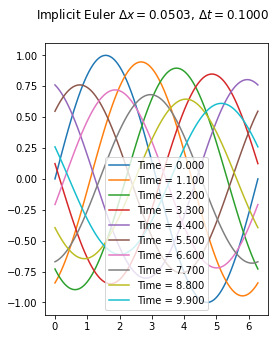

In [9]:

IE_FD_approx = Advection_implicit_euler(geom, 10, u0_lambda, 0.1, dt_save = 1, u_ex_lambda = u_ex)
IE_FD_approx.set_geom(dx = 0.05)
xx, un1 = IE_FD_approx.evolve()

# fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig,ax1 = plt.subplots(1,1,figsize=(4,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

# ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
# ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
# ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.savefig("imp_eul_central_diff_T_10_dx_%1.4f_dt_%1.5f.png"%(geom.dx,dt))

plt.show()




Final error  0.004987570580213609


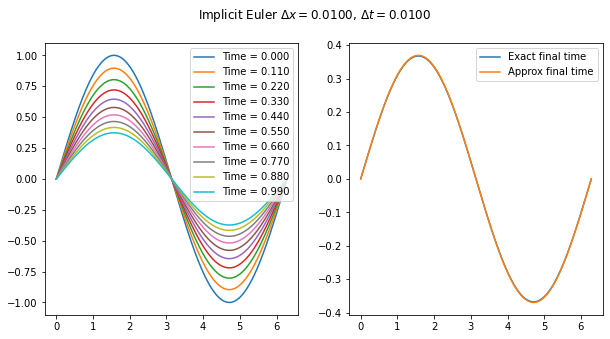

In [91]:
IE_FD_approx.set_geom(dx = 0.01)
IE_FD_approx.set_dt(0.01)
xx, un1 = IE_FD_approx.evolve()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(IE_FD_approx.times):
    ax1.plot(geom.xx, IE_FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, IE_FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Implicit Euler $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,IE_FD_approx.dt))
plt.show()


In [92]:
IE_FD_approx.set_geom(Nx=20)
np.linalg.eigvals(IE_FD_approx.lhs_matrix)

array([1.00249431, 1.0099092 , 1.02204241, 1.03856298, 1.05902027,
       1.08285627, 1.10942077, 1.13798919, 1.16778223, 1.19798724,
       1.22778029, 1.36327516, 1.35586027, 1.34372706, 1.32720649,
       1.3067492 , 1.2563487 , 1.28291321, 1.        , 1.        ])

### Crank-Nicolson

Final error  0.0013620842296200837


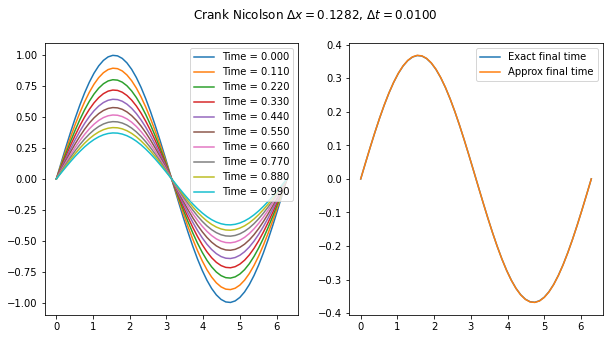

In [93]:
Nx = 50
dt = 0.01
geom = Geometry1D(0,2*np.pi,Nx)
u0_lambda = lambda x: np.sin(x)
T_end = 1.





def assemble_deriv2_matrix(geom):
    deriv2_matrix = -np.diag(2.*np.ones(geom.N),0)\
                    + np.diag(np.ones(geom.N-1),1)\
                    + np.diag(np.ones(geom.N-1),-1)
    return deriv2_matrix

deriv2_matrix = assemble_deriv2_matrix(geom)
lhs_matrix = np.eye(geom.N) - 0.5*dt/geom.dx**2*deriv2_matrix

def apply_BC_matrix(lhs_matrix):
    lhs_matrix[0,:] = 0
    lhs_matrix[0,0] = 1.
    lhs_matrix[-1,:] = 0
    lhs_matrix[-1,-1] = 1.

apply_BC_matrix(lhs_matrix)

def apply_BC_vector(rhs, uL = 0., uR = 0.):
    rhs[0] = uL
    rhs[-1] = uR



class Heat_CN:
    def __init__(self, geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = None):
        self.geom = geom
        self.T_end = T_end
        self.u0_lambda = u0_lambda
        self.u0 = self.u0_lambda(self.geom.xx)
        self.set_dt(dt)
        self.dt_save = dt_save
        self.Nt_save = np.int64(self.T_end//self.dt_save +2)
        if u_ex_lambda is not None:
            self.u_ex_lambda = u_ex_lambda
        self.assemble_lhs()

    def assemble_lhs(self):
        self.deriv2_matrix = assemble_deriv2_matrix(self.geom)
        self.lhs_matrix = np.eye(self.geom.N) - 0.5*self.dt/self.geom.dx**2*self.deriv2_matrix
        apply_BC_matrix(self.lhs_matrix)
    
    def assemble_rhs(self,un):
        rhs = un + 0.5*self.dt/self.geom.dx**2*self.deriv2_matrix@un
        apply_BC_vector(rhs)
        return rhs

    def set_geom(self,dx=None,Nx=None):
        if Nx is None:
            Nx = np.int64((self.geom.x_right-self.geom.x_left)/dx)+1
        self.geom.set_N(Nx)
        self.u0 = self.u0_lambda(self.geom.xx)
        self.assemble_lhs() 
        
    def set_dt(self,dt):
        self.dt = dt
        self.Nt = np.int64(self.T_end//self.dt+2)        
        self.assemble_lhs()
        
    def evolve(self):

        self.U_sol=np.zeros((self.Nt_save,self.geom.N))
        self.U_sol[0] = self.u0
        un = np.copy(self.u0)
        un1 = np.copy(self.u0)

        it=0
        it_save = 0
        time = 0.
        time_save = 0.
        self.times = [time]
        while ( it<self.Nt and time<self.T_end):

            time=time+self.dt
            time_save = time_save+self.dt
            it+=1
            
            rhs = self.assemble_rhs(un)
            un1 = np.linalg.solve(self.lhs_matrix, rhs)

            un = un1

            if time_save>self.dt_save:
                it_save +=1
                self.U_sol[it_save,:] = un1
                self.times.append(time)
                time_save = 0.

        if hasattr(self,"u_ex_lambda"):
            # Final time error
            self.u_ex_end = self.u_ex_lambda(time,self.geom.xx)
            self.error = np.linalg.norm(un1-self.u_ex_end)/np.linalg.norm(self.u_ex_end)
            print("Final error ",self.error)
        return self.geom.xx, un1
    
CN_FD_approx = Heat_CN(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)
xx, un1 = CN_FD_approx.evolve()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(CN_FD_approx.times):
    ax1.plot(geom.xx, CN_FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, CN_FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Crank Nicolson $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,CN_FD_approx.dt))
plt.show()




Final error  8.51114108713787e-09


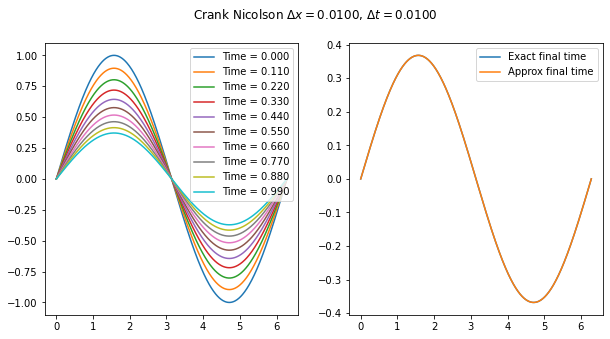

In [94]:
CN_FD_approx.set_geom(dx = 0.01)
CN_FD_approx.set_dt(0.01)
geom = CN_FD_approx.geom
xx, un1 = CN_FD_approx.evolve()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
for it, time in enumerate(CN_FD_approx.times):
    ax1.plot(geom.xx, CN_FD_approx.U_sol[it], label="Time = %1.3f"%time)

ax2.plot(geom.xx, CN_FD_approx.u_ex_end, label="Exact final time")
ax2.plot(geom.xx, un1, label="Approx final time")
ax1.legend()
ax2.legend()

fig.suptitle(r"Crank Nicolson $\Delta x=%1.4f, \, \Delta t=%1.4f$"%(geom.dx,CN_FD_approx.dt))
plt.show()


## Check order of accuracy
If $\Delta x \to 0$ then $e^{\Delta x}=\lVert u^{\Delta x} - u^{ex} \rVert \to 0$. How does it go to zero?
Check for Implicit Euler and CN with $\Delta t = \Delta x$, while for explicit Euler check with $\Delta t = \frac12 \Delta x^2$. What do you observe? Why?

Final error  0.10783641930719148
Final error  0.01931771275860287
Final error  0.002756918823510548
Final error  0.0006724725811731377
Final error  0.00016624655889016694


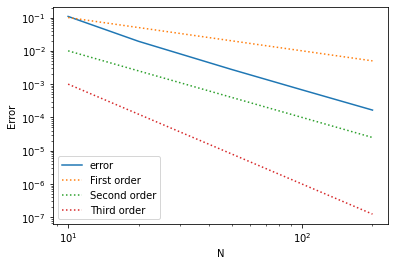

In [77]:
Ns = [10,20,50,100,200]

u0_lambda = lambda x: np.sin(x)
T_end = 1.
geom = Geometry1D(0,2*np.pi,5)

FD_approx = Heat_explicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)

# Explicit Euler
errors_EE = np.zeros(len(Ns))
for iN, N in enumerate(Ns):
    FD_approx.set_geom(Nx=N)
    FD_approx.set_dt(0.5*FD_approx.geom.dx**2)
    _, _ = FD_approx.evolve()
    
    
    errors_EE[iN] = FD_approx.error
    
plt.figure()
plt.loglog(Ns, errors_EE, label="error")
plt.loglog(Ns,1./np.array(Ns), ":",label="First order")
plt.loglog(Ns,1./np.array(Ns)**2, ":", label="Second order")
plt.loglog(Ns,1./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

Final error  0.4482222458375856
Final error  0.20805272276245462
Final error  0.06383831649171152
Final error  0.03173598586638731
Final error  0.015827801141234058


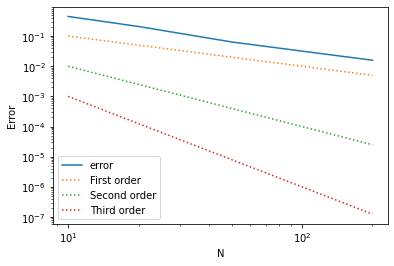

In [78]:
# Implicit Euler
Ns = [10,20,50,100,200]

u0_lambda = lambda x: np.sin(x)
T_end = 1.
geom = Geometry1D(0,2*np.pi,5)

FD_approx = Heat_implicit_euler(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)

# Implicit Euler
errors = np.zeros(len(Ns))
for iN, N in enumerate(Ns):
    FD_approx.set_geom(Nx=N)
    FD_approx.set_dt(FD_approx.geom.dx)
    _, _ = FD_approx.evolve()
    
    
    errors[iN] = FD_approx.error
    
plt.figure()
plt.loglog(Ns, errors, label="error")
plt.loglog(Ns,1./np.array(Ns), ":",label="First order")
plt.loglog(Ns,1./np.array(Ns)**2, ":", label="Second order")
plt.loglog(Ns,1./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

Final error  0.8846246239604766
Final error  0.5239431962245451
Final error  0.06730117126126732
Final error  0.016353103628053096
Final error  0.004028493234851537
Final error  0.0009996537718130346


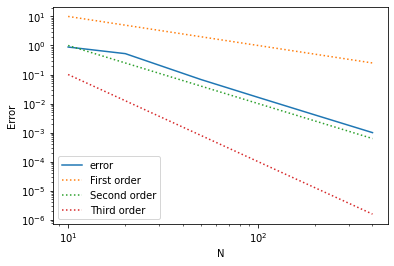

In [96]:
# Crank-Nicolson
Ns = [10,20,50,100,200,400]

u0_lambda = lambda x: np.sin(2.*x)
u_ex = lambda t,x: np.exp(-4*t)*np.sin(2*x)
T_end = 1.
geom = Geometry1D(0,2*np.pi,5)

FD_approx = Heat_CN(geom, T_end, u0_lambda, dt, dt_save = 0.1, u_ex_lambda = u_ex)

# Implicit Euler
errors = np.zeros(len(Ns))
for iN, N in enumerate(Ns):
    FD_approx.set_geom(Nx=N)
    FD_approx.set_dt(FD_approx.geom.dx)
    _, _ = FD_approx.evolve()
    
    
    errors[iN] = FD_approx.error
    
plt.figure()
plt.loglog(Ns, errors, label="error")
plt.loglog(Ns,100./np.array(Ns), ":",label="First order")
plt.loglog(Ns,100./np.array(Ns)**2, ":", label="Second order")
plt.loglog(Ns,100./np.array(Ns)**3, ":", label="Third order")
plt.xlabel("N")
plt.ylabel("Error")
plt.legend()

## Exercises
1. Different boundary conditions: periodic, Neumann, etc.
1. Different initial conditions (low and fast frequencies together, e.g. sin(x) + cos(10 x)

## Von Neumann Stability

In [102]:
# complex united is denoted by 1j in python, so the number 3+i is 
3+1j

(3+1j)

In [104]:
from nodepy import rk

In [111]:
np.imag(second_derivative_fourier(np.linspace(0,6,10)))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

                       being initialized as a RungeKuttaMethod rather than
                       as an ExplicitRungeKuttaMethod.


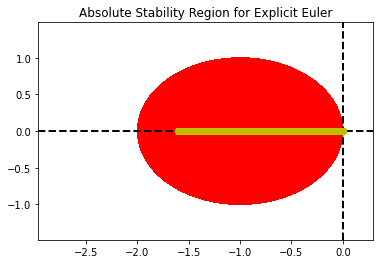

In [131]:
# Fourier analogous of second derivative operator as a function of $k*\Delta x$
second_derivative_fourier = lambda kdx: np.exp(-1j*kdx) -2+ np.exp(1j*kdx)
dt = 0.001
dx = 0.05

# Explicit Euler as a RK
A = np.array([[0]])
b = np.array([1])

# # Implicit Euler as a RK
# A = np.array([[1]])
# b = np.array([1])

# # Crank Nicolson
# A = np.array([[0,0],[0.5,0.5]])
# b = np.array([0.5,0.5])

myrk = rk.RungeKuttaMethod(A,b)
myrk.name = "Explicit Euler"
myrk.plot_stability_region()


kdxs = np.linspace(0,2*np.pi, 1000)
eigvalues = dt/dx**2*second_derivative_fourier(kdxs)

plt.plot(np.real(eigvalues), np.imag(eigvalues),'yo')


## Exercise
1. Check that for stable values of von Neumann we have stable simulations
1. Sparse implementation of matrices and decomposition of matrices to save computational time (check [Scipy sparse incomplete LU](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spilu.html)
1. Finite element implementation (either 1D or 2D with FEniCS)